In [1]:
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
from math import gcd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import umap
from Modules import file_navigation
from Modules import rnaseqTools
from matplotlib.backends.backend_pdf import PdfPages

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

color_dict = file_navigation.get_color_dict()

In [2]:
def get_lin_data():
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, na_values='Other', **params)
    df_labels = df_labels.loc[df_labels.Age>20,:]
    df_labels.sort_values('Age', inplace=True)
    
    fname = 'Datasets/Lab_Pvalb-tpm.tsv'
    df_tpm = np.log2(1+pd.read_csv(fname, **params))
    df_tpm = df_tpm.loc[:,df_labels.index].copy()
    
    arrays = [df_labels.index, df_labels['Morph-PV-types']]
    names = ('Cell', 'CellType')
    df_tpm.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_tpm.T

def get_harris_data():
    params= {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/GSE99888-labels.tsv'
    df_labels = pd.read_csv(fname, **params)
    
    fname = 'Datasets/GSE99888-tpm.tsv'
    df = np.log2(1+pd.read_csv(fname, **params))
    
    arrays = [df_labels.index, df_labels.CellType]
    names = ('Cell', 'CellType')
    df.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df.T

def get_pvalb_harris():
    df = get_harris_data()
    df = df.loc[df.index.get_level_values('CellType').str.startswith('Pvalb'),:].copy()
    
    return df

def get_cam_data(df_lin):
    fname = '/home/soma/Documents/Newest/analysisfiles/CAMmouse.txt'
    with open(fname) as f:
        cams = [line.split()[0] for line in f]
    df_cam = df_lin.loc[:,df_lin.columns.isin(cams)].copy()
    
    return df_cam

def get_differential_gene_set(target, fdr=5, method='edger'):
    assert method in ('edger', 'svm')
    target = target.split('-PV-types')[0]
    if method == 'edger':
        directory = 'Differential/edgeR/%s' % target
        fnames = glob.glob('%s/*.txt' % directory)

        genes = []

        for fname in fnames:
            df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
            df = df.loc[np.abs(df.logFC)>1]
            df_sig = df.loc[df.FDR<fdr/100]

            if df_sig.shape[0] > 0:
                genes.append(df_sig.index.tolist())
    
    elif method=='svm':
        fname = 'Mapping/Excel/%s.xlsx' % target
        df_gene = pd.read_excel(fname, sheet_name = 'Key Genes', index_col=0, header=0)
        genes = [df_gene.loc[:(fdr-1),fdr].tolist()]
        
    return genes

def get_differential_genes(targets, fdr=5, method='edger'):
    gene_sets = [get_differential_gene_set(target, fdr=fdr, method=method) for target in targets]
    gene_set = [{gene for genes in gene_set for gene in genes} for gene_set in gene_sets]
    genes = sorted({gene for genes in gene_set for gene in genes})
    
    return genes

def get_gene_signifs(target):
    directory = 'Differential/edgeR/%s' % (target.split('-PV-types')[0])
    fnames = glob.glob('%s/*.txt' % directory)
    
    gene_datas = []
    for fname in fnames:
        df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
        df = df.loc[np.abs(df.logFC)>1]
        gene_datas.append(df.FDR)
    
    gene_data = pd.concat(gene_datas, axis=1, sort=False)
    
    return gene_data.min(axis=1)

def get_signif_genes(targets, fdr=.05):
    gene_sets = pd.concat([get_gene_signifs(target) for target in targets], axis=1, sort=False)
    gene_signifs = gene_sets.min(axis=1).sort_values()
    
    gene_signifs = gene_signifs.loc[gene_signifs<=fdr]
    
    return gene_signifs

def calculate_embedding(datalist):
    reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=.1, random_state=42, metric='euclidean')
    plotlist = reducer.fit_transform(datalist)
    
    return plotlist

def get_embeddings(df, gene_sets, cutoff=.05, fdrs=[5,10,15,20], method='edger'):
    columns = ['%d_%s' % (fdr, ending) for fdr in fdrs for ending in ('X', 'Y')]
    df_embed = pd.DataFrame(np.NaN, index=df.index, columns=columns)
    
    for num, fdr in enumerate(fdrs):
        genes = get_differential_genes(gene_sets, fdr=fdr, method=method)
        df_data = df.loc[:,genes]
        df_data = df_data.loc[:,(df_data.values>0).mean(axis=0)>cutoff]
        plotlist = calculate_embedding(df_data.values)
        df_embed.iloc[:,[num*2,num*2+1]] = plotlist
    
    return df_embed

def map_to_data(df_target, df_base, df_embed, n=10):
    kept = (df_base>0).sum(axis=1)>2
    df_base = df_base.loc[kept,:]
    df_embed = df_embed.loc[kept,:]
    
    correlations = rnaseqTools.corr2(df_target.values, df_base.values)
    inds = correlations.argsort(axis=1)[:,-n:]
    df_map = pd.DataFrame(np.NaN, index=df_target.index, columns=df_embed.columns)
    for column, embed_dim in df_embed.iteritems():
        data = embed_dim.values
        df_map.loc[:,column] = np.median(data[inds], axis=1)
    
    return df_map

def get_mappings(df_target, df_base, df_embed, gene_sets,
                 n=10,
                 cutoff=0.05,
                 is_genes=False,
                 fdrs=[5,10,15,20],
                 method='edger'
                ):
    columns = ['%d_%s' % (fdr, ending) for fdr in fdrs for ending in ('X', 'Y')]
    df_map = pd.DataFrame(np.NaN, index=df_target.index, columns=columns)
    
    for fdr in fdrs:
        if is_genes:
            genes = gene_sets
        else:
            genes = get_differential_genes(gene_sets, fdr=fdr, method=method)
        df_sub_base = df_base.loc[:,genes]
        df_sub_base = df_sub_base.loc[:,(df_sub_base.values>0).mean(axis=0)>cutoff]
        df_sub_target = df_target.loc[:,df_sub_base.columns]
        columns = ['%d_X' % fdr, '%d_Y' % fdr]
        df_map.loc[:,columns] = map_to_data(df_sub_target, df_sub_base, df_embed.loc[:,columns], n=n)
    
    return df_map

def get_dimension_adjustments(df_lin, df_pvalb, df_embed, gene_sets, n=10):
    df_embed = get_embeddings(df_pvalb, gene_sets)
    df_map = get_mappings(df_lin, df_pvalb, df_embed, gene_sets, n=10)
    
    return df_embed, df_map

def plot_data(df_embed, df_map, color_dict, figname):
    harris_colors = df_embed.index.get_level_values('CellType').map(color_dict).values
    lin_colors = df_lin.index.get_level_values('CellType').map(color_dict).values
    fig = plt.figure(figsize=(8.5,11))

    for i in range(0,df_embed.shape[1],2):
        plotlist = df_embed.iloc[:,i:i+2].values
        maplist = df_map.iloc[:,i:i+2].values
        fdr = df_embed.columns[i][:-2]

        col = (i//2) % 2
        row = (i//2) // 2
        ax = fig.add_axes([.14+.4*col, .6 - .3*row, .33, .255])
        ax.set_title('FDR = %s%%' % fdr, fontsize=12)
        ax.set_xticks([]), ax.set_yticks([])
        ax.scatter(plotlist[:,0], plotlist[:,1], color=harris_colors, s=8, zorder=0)
        ax.scatter(maplist[:,0], maplist[:,1], facecolor=lin_colors, edgecolor='#000000', s=32, zorder=1, linewidth=1)

    fig.savefig('Figures/%s.pdf' % figname)
    plt.show()
    plt.close()
    
    return

def add_labels_csaba(df, df_labels):
    is_bottom = np.logical_and(df.X>-2, df.Y<0)
    is_right = np.logical_and(df.X>-2.1, df.Y>0)
    is_center = np.logical_and(df.X>-3.6, ~np.logical_or(is_right, is_bottom))
    is_left = ~np.logical_or(is_bottom, np.logical_or(is_right, is_center))
    df_labels.loc[is_bottom.values,'Csaba'] = 'Group1'
    df_labels.loc[is_right.values,'Csaba'] = 'Group2'
    df_labels.loc[is_center.values,'Csaba'] = 'Group3'
    df_labels.loc[is_left.values,'Csaba'] = 'Group4'
    
    return

def add_labels_soma(df, df_labels):
    is_left = np.logical_and(df.X<-3, df.Y>(.2*df.X+2.9))
    is_right = np.logical_and(df.X>-2.5,df.Y>1.55)
    is_bottom = np.logical_and(df.X>-1,df.Y<1.55)
    is_center = np.logical_and(df.X<-1, df.Y<1.55)
    df_labels.loc[is_bottom.values,'Soma'] = 'Group1'
    df_labels.loc[is_right.values,'Soma'] = 'Group2'
    df_labels.loc[is_center.values,'Soma'] = 'Group3'
    df_labels.loc[is_left.values,'Soma'] = 'Group4'
    
    return

def get_classifications(df):
    index = df.index.get_level_values('Cell')
    columns = ['CellType', 'Csaba', 'Soma']
    df_labels = pd.DataFrame('', index=index, columns=columns)
    
    df_labels.CellType = df.index.get_level_values('CellType')
    add_labels_csaba(df, df_labels)
    add_labels_soma(df, df_labels)
    
    return df_labels

def get_lcm(*args):
    """
    get lowest common multiple of a series of numbers, and what they need to be multiplied by
    to get that large
    """
    lcm = 1
    for number in args:
        lcm = (lcm * number) // gcd(lcm, number)
    
    multiples = [lcm // number for number in args]
    
    return lcm, multiples
    

def get_sorted_order(df_tpm, labels):
    """
    hierarchically sort a dataframe
    despite different cell types having different number of cells, we want to weigh them evenly
    """
    
    # get lowest common multiple, and how much cells need to be multiplied by
    counts = labels.value_counts()
    lcm, multiple = get_lcm(*counts)
    
    # construct artifically inflated dataset
    datalist = df_tpm.values.T
    datalists = []
    for label, mult in zip(counts.index, multiple):
        data = datalist[:,labels==label]
        datalists.append(np.tile(data, mult))
    datalist = np.hstack(datalists)
    
    # do hierarchical sorting
    Z = linkage(datalist, method='average', metric='euclidean')
    D = dendrogram(Z, no_plot=True)
    index = D['leaves']
    
    df_tpm = df_tpm.iloc[:,index]
    
    return df_tpm

def do_heatmap(fig, axrange, df_tpm, labels, tick_size=6, order=['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC']):
    # get data of interest
    if len(order) == 0:
        order = sorted(set(labels.tolist()))
    high = df_tpm.values.max()*1.01
    
    # sort genes
    df_tpm = get_sorted_order(df_tpm, labels)
    df_tpm = df_tpm.T
    
    # calculate target sizes
    Left, Bottom, Width, Height = axrange
    dW = .0022
    W = (Width - dW*(len(order)-1)) / df_tpm.shape[1]
    left = Left
    
    # plot data
    for col, celltype in enumerate(order):
        # get parameters for each column
        df_celltype = df_tpm.loc[:,(labels==celltype)]
        width = W * df_celltype.shape[1]
        
        # generate axes
        ax = fig.add_axes([left, Bottom, width, Height])
        ax.set_title(celltype, fontsize=5)
        if col != 0 and False:
            ax.spines['left'].set_visible(False)
        if col != len(order)-1 and False:
            ax.spines['right'].set_visible(False)
        ax.set_xticks([]), ax.set_yticks([])
        
        # do plot
        pcol = ax.pcolor(df_celltype.values, vmin=0, vmax=high, cmap=mpl.cm.Reds)
        pcol.set_edgecolor('face')
        ax.axis([0,df_celltype.shape[1], 0, df_celltype.shape[0]])
        
        left += width + dW
    
    cax = fig.add_axes([Left+Width+.01, Bottom, .01, Height])
    plt.colorbar(pcol, cax=cax, orientation='vertical')
    cax.tick_params(size=1, labelsize=5, pad=1)
    
    return

In [3]:
%%time

# read in data

df_pvalb = get_pvalb_harris()
df_lin = get_lin_data()
df_cam = get_cam_data(df_lin)
df_cam = df_cam.loc[:,(df_cam.values>1).sum(axis=0)>2]
labels = df_cam.index.get_level_values('CellType')

CPU times: user 47.1 s, sys: 1.31 s, total: 48.4 s
Wall time: 48.4 s


/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/soma/anaconda3/envs/analyze/lib/p

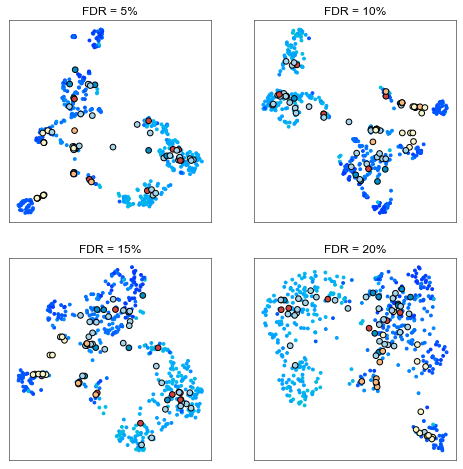

CPU times: user 18 s, sys: 4.39 s, total: 22.4 s
Wall time: 15.7 s


In [4]:
%%time

# get embeddings and mappings

gene_sets = ['Morph', 'MorphMarker', 'MorphDirectional']
df_embed = get_embeddings(df_pvalb, gene_sets)
df_map = get_mappings(df_lin, df_pvalb, df_embed, gene_sets, n=10, is_genes=False)
plot_data(df_embed, df_map, color_dict, 'Temporary Plots Morph + MorphMarker + MorphDirectional')

df_embed_15 = df_embed.loc[:,['15_X', '15_Y']]
df_map_15 = df_map.loc[:,['15_X', '15_Y']]
df_embed_15.columns = ['X', 'Y']
df_map_15.columns = ['X', 'Y']
df_embed_15.to_csv('Mapping/DifferentialMapping/Harris.tsv', sep='\t')
df_map_15.to_csv('Mapping/DifferentialMapping/Lab_Pvalb.tsv', sep='\t')
df_labels = get_classifications(df_embed_15)
df_labels.to_csv('Mapping/DifferentialMapping/Manual_Classification.tsv', sep='\t')
df_labels.to_csv('Datasets/Harris_Pvalb-transcriptional_labels.tsv', sep='\t')

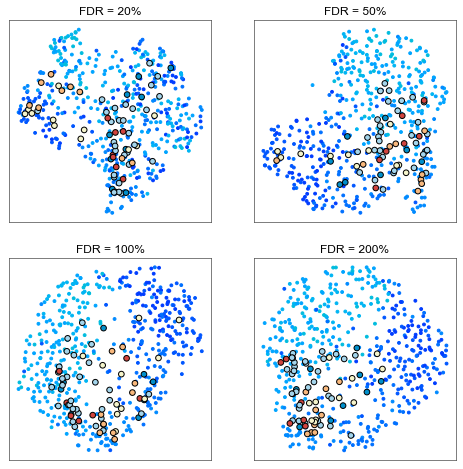

CPU times: user 13.8 s, sys: 4.21 s, total: 18 s
Wall time: 11.3 s


In [5]:
%%time

# get embeddings and mappings

gene_sets = ['Morph', 'MorphMarker', 'MorphDirectional']
df_embed = get_embeddings(df_pvalb, gene_sets, method='svm', fdrs=[20, 50, 100, 200])
df_map = get_mappings(df_lin, df_pvalb, df_embed, gene_sets, n=10, is_genes=False, method='svm', fdrs=[20, 50, 100, 200])
plot_data(df_embed, df_map, color_dict, 'Temporary Plots Morph + MorphMarker + MorphDirectional')

df_embed_100 = df_embed.loc[:,['100_X', '100_Y']]
df_map_100 = df_map.loc[:,['100_X', '100_Y']]
df_embed_100.columns = ['X', 'Y']
df_map_100.columns = ['X', 'Y']
df_embed_100.to_csv('Mapping/DifferentialMapping/Harris_Multi.tsv', sep='\t')
df_map_100.to_csv('Mapping/DifferentialMapping/Lab_Pvalb_Multi.tsv', sep='\t')
df_labels = get_classifications(df_embed_15)
df_labels.to_csv('Mapping/DifferentialMapping/Manual_Classification_Multi.tsv', sep='\t')
df_labels.to_csv('Datasets/Harris_Pvalb-transcriptional_labels_Multi.tsv', sep='\t')